In [61]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier

In [73]:
import optuna
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    make_scorer,
    roc_curve,
    auc,
)
import matplotlib.pyplot as plt


## Read fingerprint file and experimental file

read fingerprint file and experiment data file

In [63]:
receptors = pd.read_csv(
    "/Users/xiaomuou620/Desktop/PRIVATE_DATA/hallucinome.csv"  # have aligned the name Bromo-dragonFLY to Bromo-DragonFLY
)
fingerprints = pd.read_csv('../../data/ExperimentData/MACCS_fingerprints.csv')

print(receptors.head())
print(receptors.shape)
print(fingerprints.shape)

  receptor gprotein        drug    Emax  Emax_SE    TCoeff  TCoeff_SE  \
0    5HT1A      Gi1   25C-NBOMe  999.00   999.00       NaN        NaN   
1    5HT1A      Gi1    25I-NBMD   18.62     2.06  8.878197   0.201061   
2    5HT1A      Gi1   25I-NBOMe   24.53     3.28  7.947086   0.195392   
3    5HT1A      Gi1  25T7-NBOMe   22.00     3.87  7.457872   0.217788   
4    5HT1A      Gi1  4-AcO-MALT   38.93     5.16  7.417719   0.148907   

    logEmEC  logEmEc_Lower  logEmEc_Upper   pEC50  pEC50_SE  N  
0       NaN            NaN            NaN  999.00    999.00  3  
1  8.879980       8.529060       9.225551    7.61      0.30  3  
2  7.949698       7.607359       8.284201    6.56      0.28  3  
3  7.462423       7.078398       7.832796    6.12      0.30  3  
4  7.420284       7.158531       7.674340    5.83      0.20  3  
(4059, 13)
(43, 168)


### Experimental data processing

In [64]:
# replace 999 in Emax with 0
receptors["Emax"] = receptors["Emax"].replace(999, 0)
# print(receptors.head())

# collect receptors for each drug
receptor_emax_mapping = (
    receptors.groupby(["drug", "receptor"])["Emax"].max().reset_index()
)
# print(receptor_emax_mapping.head())

# pivot the table to have drugs as rows and receptors as columns
receptor_emax_mapping_pivot = receptor_emax_mapping.pivot(
    index="drug", columns="receptor", values="Emax"
).reset_index()
print(receptor_emax_mapping_pivot.head())

receptor_emax_mapping_pivot.fillna(0, inplace=True)
print(receptor_emax_mapping_pivot.shape)

receptor        drug      5HT1A       5HT1B   5HT1D   5HT1E       5HT1F  \
0          25C-NBOMe  13.047601    0.000000   61.56    0.00    0.000000   
1           25I-NBMD  27.200000   84.239297   91.94  105.26  102.099230   
2          25I-NBOMe  45.370000    0.000000   53.65   33.92   64.596780   
3         25T7-NBOMe  31.991315    0.000000   31.81    0.00   69.116817   
4         4-AcO-MALT  50.677696  126.170618  101.04  115.53  102.552716   

receptor   5HT2A  5HT2B   5HT2C  5HT5A  ...  Alpha2B  Alpha2C  Beta1AR  \
0         126.52  67.19   98.15   0.00  ...      0.0      0.0      0.0   
1         102.02  45.49   79.79   0.00  ...      0.0      0.0      0.0   
2         108.36  72.04  104.43  27.97  ...      0.0      0.0      0.0   
3          99.15  53.73   94.85  36.81  ...      0.0      0.0      0.0   
4         102.61  68.11  110.35  43.88  ...      0.0      0.0      0.0   

receptor  Beta2AR  Beta3AR  DRD1   DRD2   DRD3  DRD4   DRD5  
0             0.0      0.0   0.0  50.60   

binarize the experiment data file -> create multilabel for receptors

In [65]:
# set the threshold for binarization
threshold = 0

# transform the data
multi_label_data = receptor_emax_mapping_pivot.copy()
receptors = multi_label_data.columns[1:]  

# binarize the receptors
multi_label_data[receptors] = (multi_label_data[receptors] > threshold).astype(int)

print(multi_label_data.shape)
print(fingerprints.shape)


(44, 26)
(43, 168)


### Merge feature and labels

merge features and labels -> to ensure the features and labels match based on drugs

Here, labels have 44 lines and fingerprints have 43 lines, including the header.

Since I cannot find the category and SMILES of METALLED, when merging the data, METALLED data will be disgarded.


Only leave 5HT6 as target

In [66]:
# merge the data based on the drug names (make sure the names are lower case when comparing)
drug_receptor_label = pd.merge(
    fingerprints.assign(Name_lower=fingerprints["Name"].str.strip().str.lower()),
    multi_label_data.assign(
        drug_lower=multi_label_data["drug"].str.strip().str.lower()
    ),
    left_on="Name_lower",
    right_on="drug_lower",
    how="left",
)

# change back to the original drug name
drug_receptor_label.drop(columns=["Name_lower", "drug_lower"], inplace=True)

print(fingerprints.shape)
print(drug_receptor_label.shape)
# drug_receptor_label.to_csv("drug_receptor_label.csv", index=False)

(43, 168)
(43, 194)


In [67]:
drug_receptor_label_drop = drug_receptor_label.drop(columns=["Name", "drug"])
drug_label = drug_receptor_label_drop[
    drug_receptor_label_drop.columns[1:167].tolist() + ["5HT6"]
]

print(drug_label.head())
# drug_label.to_csv('/Users/xiaomuou620/Desktop/PRIVATE_DATA/selected_file_multilabel.csv', index=False)

# drug_dict = drug_label.to_dict()
# print(drug_dict)
# print(drug_label['5-HT2A'].value_counts())

   1  2  3  4  5  6  7  8  9  10  ...  158  159  160  161  162  163  164  165  \
0  0  0  0  0  0  0  0  0  0   0  ...    1    1    0    1    1    1    1    1   
1  0  0  0  0  0  0  0  0  0   0  ...    1    1    1    1    1    1    1    1   
2  0  0  0  0  0  0  0  0  0   0  ...    1    0    1    1    1    1    1    1   
3  0  0  0  0  0  0  0  0  0   0  ...    1    0    1    1    1    1    1    1   
4  0  0  0  0  0  0  0  0  0   0  ...    1    0    1    1    1    1    1    1   

   166  5HT6  
0    0     1  
1    0     1  
2    0     1  
3    0     1  
4    0     1  

[5 rows x 167 columns]


# Training

Since MACCS only has 166 bits and the first bit 0 always unset and may be ignored. Only bits 1-166 will be set

In [68]:
X = drug_label.iloc[:, 0:166]
y = drug_label.iloc[:, 166:]

print(X.shape, y.shape)
print(X.head())
print(y.head())
# 


(43, 166) (43, 1)
   1  2  3  4  5  6  7  8  9  10  ...  157  158  159  160  161  162  163  164  \
0  0  0  0  0  0  0  0  0  0   0  ...    1    1    1    0    1    1    1    1   
1  0  0  0  0  0  0  0  0  0   0  ...    1    1    1    1    1    1    1    1   
2  0  0  0  0  0  0  0  0  0   0  ...    1    1    0    1    1    1    1    1   
3  0  0  0  0  0  0  0  0  0   0  ...    1    1    0    1    1    1    1    1   
4  0  0  0  0  0  0  0  0  0   0  ...    1    1    0    1    1    1    1    1   

   165  166  
0    1    0  
1    1    0  
2    1    0  
3    1    0  
4    1    0  

[5 rows x 166 columns]
   5HT6
0     1
1     1
2     1
3     1
4     1


## Optuna + Nested CV

In [77]:
# Nested cross-validation setup
outer_ncv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_ncv = KFold(n_splits=5, shuffle=True, random_state=43)


# Define the objective function for the Inner loop
def objective(trial, X_train_inner, y_train_inner):
    # Define hyperparameters to optimize
    n_estimators = trial.suggest_int("n_estimators", 10, 100)
    max_depth = trial.suggest_int("max_depth", 5, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 5)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    # Create a random forest classifier
    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42,
    )

    # Cross-validation for hyperparameter tuning
    scoring = make_scorer(
        accuracy_score, greater_is_better=True
    )  
    cv_scores = cross_val_score(
        rf_classifier, X_train_inner, y_train_inner, cv=inner_ncv, scoring=scoring
    )
    return cv_scores.mean() 

[I 2025-01-07 15:47:24,972] A new study created in memory with name: no-name-e89b00b4-fcfb-40e4-90b0-137cbb9a66e5
/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, 

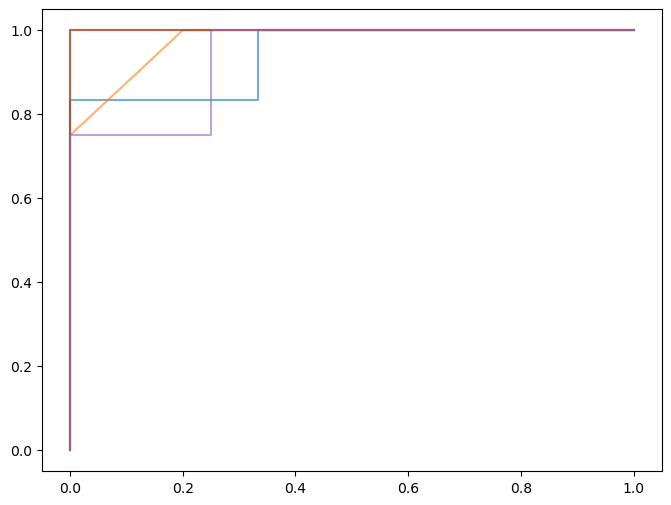

In [78]:
# Outer loop: Statistical evaluation
outer_scores = []
ncv_label_scores = {label: [] for label in y.columns}

# For ROC plotting
mean_fpr = np.linspace(0, 1, 100)  # Average FPR for interpolation
tprs = []  # TPRs for all folds
aucs = []  # AUC scores for all folds

plt.figure(figsize=(8, 6))  # Initialize the plot

for fold, (train_index, test_index) in enumerate(outer_ncv.split(X, y), start=1):
    # Split data into training and testing sets for the outer fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Skip fold if only one class is present
    if len(np.unique(y_test)) < 2:
        print(
            f"Fold {fold}: Only one class present in y_test. Skipping ROC computation."
        )
        continue

    # Inner loop: Hyperparameter search
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=50)

    # Train the model using the best hyperparameters
    best_params = study.best_params
    best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
    best_rf_classifier.fit(X_train, y_train)

    # Predict on the test set
    y_test_pred = best_rf_classifier.predict(X_test)
    y_test_pred_proba = best_rf_classifier.predict_proba(X_test)[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    # Plot ROC curve for the current fold
    plt.plot(fpr, tpr, alpha=0.6, label=f"Fold {fold} (AUC = {roc_auc:.2f})")

    # Interpolate TPR for consistent plotting
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

    # Evaluate the model on the outer fold's test set
    outer_scores.append(
        {
            "accuracy": accuracy_score(y_test, y_test_pred),
            "f1_score": f1_score(y_test, y_test_pred, average="weighted"),
        }
    )



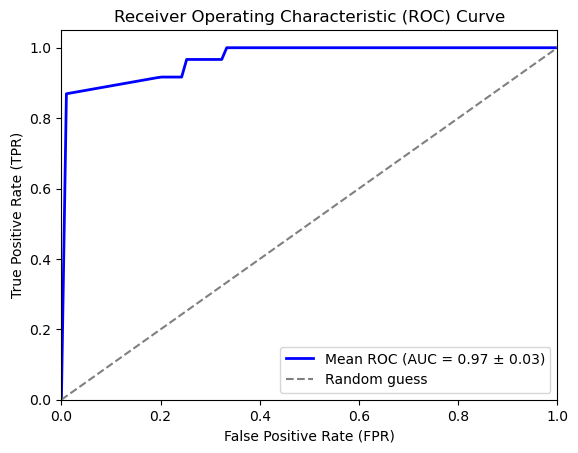

Accuracy: Mean = 0.86, Std = 0.09
F1_score: Mean = 0.86, Std = 0.09


In [79]:
# Compute and plot mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0  # Ensure the curve ends at (1, 1)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(
    mean_fpr,
    mean_tpr,
    color="blue",
    lw=2,
    label=f"Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})",
)

# Add reference line and format the plot
plt.plot([0, 1], [0, 1], color="grey", linestyle="--", label="Random guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# Calculate mean and standard deviation for overall metrics
metrics_summary = {
    key: [score[key] for score in outer_scores] for key in outer_scores[0]
}
for metric, values in metrics_summary.items():
    print(
        f"{metric.capitalize()}: Mean = {np.mean(values):.2f}, Std = {np.std(values):.2f}"
    )
